# Assessment graphical interface


In order to assess relevance of documents, you will have to create a web interface that displays the topic/query, and a given document list. Each URL in the list should be clickable to lead to the document text, pooled either from ES raw-html field or live from original URL. You would probably take as a start the web GUI you used for vertical search in HW3.

The interface has to contain an input fields for each URL/snippet in order for the assessor to input a 3-scale grade “non-relevant”, “relevant”, “very relevant” (or 0,1,2). The can be an input checkboxes, radio boxes, dropdown list, text input box, etc. The interface should also record the assessor ID (by name). You can add a “submit” button somewhere, and a count of how many documents have been assessed.

The input assessments should be stored in a QREL file (txt format) as

QueryID AssessorID DocID Grade

QueryID AssessorID DocID Grade

In [1]:
import sys
import os
import math
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [141]:
class OpenRead:
    def __init__(self):
        pass
        
    def file_open_read(self, filename):
        with open(filename,encoding="utf-8") as file:
            file = file.readlines()
        file_content = [i.split("\t") for i in file]
        modified_file_content = []
        if "karan" in filename.lower():
            for content in file_content:
                if "Karan" in content:
                    if len(content[0]) != 6:
                        content[0] = content[0].split()[-1]
                    if len(content) != 4:
                        split_content = content[-1].split()
                        content[-1] = split_content[0]
                        content.append(split_content[-1].strip("\\"))
                    else:
                        content[-1] = content[-1].strip("\\\n")
                    modified_file_content.append(content)
            file_content = modified_file_content
        else:   
            for i in file_content:
                if i != ["\n"]:
                    try:
                        i[3] = i[3].strip("\n")
                    except:
                        print (i)
                        return 
                else:
                    file_content.remove(i)
        return file_content
    
    def list_to_dict(self, list_to_change):
        dict_query = {}
        for element in list_to_change:
            dict_query[element[2]] = element[:2] + [element[-1]]
        return dict_query 
    
    def combine_result(self, result_query):
        dict_monica_query = result_query[0]
        dict_bagus_query = result_query[1]
        dict_karan_query = result_query[2]
        new_dict = {}
        for url in dict_monica_query:
            if url in dict_bagus_query and url in dict_karan_query:
                result_1 = [dict_bagus_query[url][2]]
                result_2 = [dict_karan_query[url][2]]
                new_dict[url] = [dict_monica_query[url][2]] + result_1 + result_2
            else:
                if url not in dict_karan_query and url in dict_bagus_query:
                    ## add the same entry
                    new_dict[url] = [dict_monica_query[url][2]] + result_1 + result_1
        return new_dict
    
    def filename_open_to_list(self):
        filenames = [["152601_monica.txt", "152601_bagus.txt", "152601_karan.rtf"],["152602_monica.txt", "152602_bagus.txt", "152602_karan.rtf"],
                     ["152603_monica.txt", "152603_bagus.txt", "152603_karan.rtf"]]
        self.complete_result_set = {}
        for name in filenames:
            result_query = []
            for query_each in name:
                list_per_query = self.file_open_read(query_each)
                dict_per_query = self.list_to_dict(list_per_query)
                result_query.append(dict_per_query)
                print ("Completed parsing", query_each)
            new_dict_combined = self.combine_result(result_query)    
            self.complete_result_set[query_each.split("_")[0]] = new_dict_combined
        file_name_overall, file_name_binary = self.overall_relevance_judgement()
        return file_name_overall, file_name_binary
    
    ## get overall judgement on a query
    def overall_relevance_judgement(self):
        file_name_overall = ("crawler_query") + "_overall.txt"
        file_name_binary = ("crawler_query") + "_binary.txt"
        for query in self.complete_result_set:
            overall_relevance_dict = {}
            binary_relevance_dict = {}
            for key,value in self.complete_result_set[query].items():
                try:
                    value = int(statistics.mode(value))
                except Exception as e:
                    value = 1 #median value since no mode was found
                if value == 1:
                    bin_value = 0
                elif value == 2:
                    bin_value = 1
                binary_relevance_dict[key] = bin_value 
                overall_relevance_dict[key] = value
            self.write_into_file(query, file_name_binary, binary_relevance_dict)
            self.write_into_file(query, file_name_overall, overall_relevance_dict)
        return file_name_overall, file_name_binary
    
    def write_into_file(self, query, file_name, dictionary):
         with open(file_name, "a+") as file:
            for key in dictionary:
                str_file = str(query) + " " + str(key) + " " + str(dictionary[key]) + "\n"
                file.write(str_file)
                    
            
    

In [142]:
open_read_object = OpenRead()
file_name_overall, file_name_binary = open_read_object.filename_open_to_list()

Completed parsing 152601_monica.txt
Completed parsing 152601_bagus.txt
Completed parsing 152601_karan.rtf
Completed parsing 152602_monica.txt
Completed parsing 152602_bagus.txt
Completed parsing 152602_karan.rtf
Completed parsing 152603_monica.txt
Completed parsing 152603_bagus.txt
Completed parsing 152603_karan.rtf


# Write your own trec_eval

Write a program that replicates trec_eval functionality. Input : a ranked list file and QREL file, both in TREC format. Both files can contain results and assessments for multiple queryIDs.

First, sort docIDS per queryID by score. Then for each query compute R-precision, Average Precision, nDCG, precision@k and recall@k and F1@k (k=5,10, 20, 50, 100). Average these numbers over the queryIDs. If run with -q option your program should display the measures for each queryID before displaying the averages.

Run your treceval on HW1 runs with the qrel provided to confirm that it gives the same values as the provided treceval.

Run your trec_eval on the HW3 vertical search engine.

In [295]:
class JudgementClassification():
    def __init__(self, file_name_overall = None, file_name_binary = None, query_num = None, trec_file = None):
        self.indices = [5-1, 10-1, 20-1, 50-1, 100-1, 200-1]
        self.result_dict = {}
        self.query_num = query_num
        self.binary_filename = file_name_binary
        self.overall_filename = file_name_overall
        self.trec_file = trec_file
        self.query_num = query_num
        self.ndgc_all = {}
        
    def call_func(self):
        self.result_dict = {}
        if self.overall_filename:
            self.overall_relevance_dict = self.qrel_parser(self.overall_filename)
            self.overall_trec_dictionary = self.trec_relevance_reader(self.trec_file)  
            self.overall_trec_dictionary  = self.trec_relevance_conversion(self.overall_trec_dictionary, self.overall_relevance_dict) 
            self.ndgc_all = {}
            for key in self.overall_trec_dictionary:
                self.ndgc_all[key] = self.calculate_ndcg(self.overall_trec_dictionary[key])   
        else:
            print ("Since overall relevance file is not provided the ndgc value will be 0")
        if self.binary_filename:
            self.binary_relevance_dict = self.qrel_parser(self.binary_filename)
            self.binary_trec_dictionary = self.trec_relevance_reader(self.trec_file)  
            self.binary_trec_dictionary  = self.trec_relevance_conversion(self.binary_trec_dictionary, self.binary_relevance_dict) 
            for key in self.binary_trec_dictionary:
                print ("key",key)
                if not self.overall_filename:
                     self.ndgc_all[key] = 0
                self.df_prec_rec_f1, self.average_precision, self.r_precision_value = self.precision_overall_qrel(self.binary_trec_dictionary[key]) 
                if self.average_precision:
                    self.result_dict[key] = [self.average_precision, self.df_prec_rec_f1, self.r_precision_value, self.ndgc_all[key]]
        df_all_results = [i[1] for i in list(self.result_dict.values())][:]
        self.print_result(self.query_num)
        return df_all_results
    
    def trec_relevance_reader(self, trec_file):
        with open(trec_file) as file:
            read_file = file.readlines()
        dictionary_query = {}
        value = 0 #initial value
        for i in read_file:
            split_i = i.strip("\n").split(" ")
            key = split_i[0]
            if split_i[1] == "Q0":
                split_i.pop(1)
            if key not in dictionary_query:
                temp_dict = {}
                temp_dict[split_i[1]] = value
                dictionary_query[key] = temp_dict
            else:
                temp_dict[split_i[1]] = value
        return dictionary_query
    
    def trec_relevance_conversion(self, dictionary_query, rel_dictionary):
        new_temp_dict = {}
        for key in dictionary_query:
            temp_dict_each_query = dictionary_query[key]
            if key in rel_dictionary:
                for docid in dictionary_query[key]:
                    if docid in rel_dictionary[key]:
                        temp_dict_each_query[docid] = rel_dictionary[key][docid]
            new_temp_dict[key] = temp_dict_each_query
        return new_temp_dict
        
        
    ## The formula for r precision is rank divided by total relevant docs
    def r_precision(self, prec_dict):
        self.r_precision_value = sum(list(prec_dict.values())[:self.total_relevance]) / self.total_relevance
        return self.r_precision_value
    
    def precision_recall_f1(self):
        list_of_indices =  range(1,201)
        prec = []
        recall = []
        f1 = []
        self.df_prec_rec_f1 = pd.DataFrame(columns = ["prec","recall","f1"], index = list_of_indices)
        for i in list_of_indices:
            prec.append(sum(list(self.binary_relevance_dict.values())[:i])/i)
            recall.append(sum(list(self.binary_relevance_dict.values())[:i])/self.total_relevance)
            sum_prec_recall = prec[i-1] + recall[i-1]
            if sum_prec_recall == 0:
                sum_prec_recall = 0.0001
            f1.append((2 * prec[i-1] * recall[i-1])/sum_prec_recall)
        self.df_prec_rec_f1["prec"] = prec
        self.df_prec_rec_f1["recall"] = recall
        self.df_prec_rec_f1["f1"] = f1
        self.average_precision = self.df_prec_rec_f1["prec"].mean()
        return self.df_prec_rec_f1, self.average_precision
    
    def calculate_ndcg(self, overall_relevance):
        ## log relevance 
        print ("Overall rele: ",len(overall_relevance.keys()))
        log_relevance = [1/(math.log2(i+1)) for i in range(1,len(overall_relevance)+1)]
        print ("length of log relevance: ", len(log_relevance))
        ## discounted gain gives more preference to the docs which are relevant and high in order
        discounted_gain = [list(overall_relevance.values())[j]*log_relevance[j] for j in range(len(overall_relevance))]
        print ("discounted gain: ", sum(discounted_gain))
        ## ideal DCG is to be used to divide the result since each query can have varied number of retrived docs
        relative_relevance_sorted = sorted(overall_relevance.items(), key = lambda x:x[1], reverse = True)
        ## relative_relevance_sorted is an ordered dictionary
        normalized_gain = [relative_relevance_sorted[j][1]*log_relevance[j] for j in range(len(overall_relevance))]
        print ("normalized_gain: ", sum(normalized_gain))
        ## divide the sum of discounted gain by the sum of normalized to get the ndcg
        ndcg = sum(discounted_gain)/sum(normalized_gain)
        print ("ndcg", ndcg, "\n")
        return ndcg
    
    def print_result(self, query_num):
        if query_num:
            print ("Results for query: ",query_num)
            average_precision = self.result_dict[query_num][0]
            df_prec_rec_f1 = self.result_dict[query_num][1]
            r_precision_value = self.result_dict[query_num][2]
            ndcg = self.result_dict[query_num][3]
            self.print_data(average_precision, df_prec_rec_f1, r_precision_value, ndcg)
        else:
            print ("\n Result on all queries")
            avg_precision_mean  = statistics.mean([j[0] for j in list(self.result_dict.values())])
            avg_prec_recall_at_k  = ([j[1] for j in list(self.result_dict.values())])[:]
            new_combined_df = avg_prec_recall_at_k[0][:]
            for query_df in avg_prec_recall_at_k[1:]:
                new_combined_df += query_df
            new_combined_df = new_combined_df / len(self.result_dict)
            avg_r_precision  = ([j[2] for j in list(self.result_dict.values())])
            avg_r_precision = statistics.mean(avg_r_precision)
            avg_ndgc  = ([j[3] for j in list(self.result_dict.values())])
            avg_ndgc = statistics.mean(avg_ndgc)
            self.print_data(avg_precision_mean, new_combined_df, avg_r_precision, avg_ndgc)
            
    def print_data(self,avg_precision_mean, new_combined_df, avg_r_precision, avg_ndgc):
        print ("Average precision: ", avg_precision_mean)
        print ("**********************************************************************")
        for i in self.indices:
            print ("Avg Precision at {0} : {1}".format(i+1, new_combined_df["prec"][i+1]))
            print ("Avg Recall at {0} : {1}".format(i+1, new_combined_df["recall"][i+1]))
            print ("Avg F1 at {0} : {1}".format(i+1, new_combined_df["f1"][i+1]))
            print ("********************************************************************")
        print ("Average R precision : {}".format(avg_r_precision))
        print ("Average NDCG score: ", avg_ndgc)

    def qrel_parser(self, filename):
        with open(filename) as file:
            read_file = file.readlines()
        dictionary_query = {}
        for i in read_file:
            split_i = i.strip("\n").split(" ")
            key = split_i[0]
            if split_i[1] == "0":
                split_i.pop(1)
            if key not in dictionary_query:
                temp_dict = {}
                temp_dict[split_i[1]] = int(split_i[2])
                dictionary_query[key] = temp_dict
            else:
                temp_dict[split_i[1]] = int(split_i[2])
        return dictionary_query
    
    def precision_overall_qrel(self, dictionary_query):
        precision_values = []
        self.binary_relevance_dict = dictionary_query
        self.total_relevance = sum(list(self.binary_relevance_dict.values()))
        if self.total_relevance == 0:
            return None, None, None
        self.df_prec_rec_f1, self.average_precision = self.precision_recall_f1()
        self.r_precision_value = self.r_precision(dictionary_query)
        print ("df_prec_rec_f1",self.df_prec_rec_f1)
        return self.df_prec_rec_f1, self.average_precision, self.r_precision_value
        

In [268]:
judgement_result_object = JudgementClassification(file_name_overall = None,
                                                  file_name_binary = "qrels.adhoc.51-100.AP89.txt", 
                                                  trec_file = "okapi_tfidf")
judgement_result = judgement_result_object.call_func()

Since overall relevance file is not provided the ndgc value will be 0
key 85
key 59
key 56
key 71
key 64
key 62
key 93
key 99
key 58
key 77
key 54
key 87
key 94
key 100
key 89
key 61
key 95
key 68
key 57
key 97
key 98
key 60
key 80
key 63
key 91

 Result on all queries
new_combined_df          prec    recall        f1
1    0.000000  0.000000  0.000000
2    0.500000  0.005464  0.010811
3    0.666667  0.010929  0.021505
4    0.750000  0.016393  0.032086
5    0.800000  0.021858  0.042553
6    0.833333  0.027322  0.052910
7    0.857143  0.032787  0.063158
8    0.875000  0.038251  0.073298
9    0.777778  0.038251  0.072917
10   0.800000  0.043716  0.082902
11   0.818182  0.049180  0.092784
12   0.750000  0.049180  0.092308
13   0.692308  0.049180  0.091837
14   0.714286  0.054645  0.101523
15   0.733333  0.060109  0.111111
16   0.687500  0.060109  0.110553
17   0.647059  0.060109  0.110000
18   0.611111  0.060109  0.109453
19   0.631579  0.065574  0.118812
20   0.600000  0.065574  0.118227


In [308]:
judgement_result_object = JudgementClassification(file_name_overall = "crawler_query_overall.txt",
                                                  file_name_binary = "crawler_query_binary.txt", 
                                                  trec_file = "crawler_query_overall.txt", query_num = "152601")
judgement_result = judgement_result_object.call_func()

Overall rele:  200
length of log relevance:  200
discounted gain:  55.19248182479027
normalized_gain:  56.700439420079796
ndcg 0.9734048340592666 

Overall rele:  200
length of log relevance:  200
discounted gain:  54.17333033807613
normalized_gain:  58.11907033717446
ndcg 0.9321093751808597 

Overall rele:  200
length of log relevance:  200
discounted gain:  17.11430839226953
normalized_gain:  18.13130107257709
ndcg 0.9439095586005283 

key 152601
df_prec_rec_f1          prec  recall        f1
1    1.000000   0.008  0.015873
2    1.000000   0.016  0.031496
3    1.000000   0.024  0.046875
4    1.000000   0.032  0.062016
5    1.000000   0.040  0.076923
6    1.000000   0.048  0.091603
7    1.000000   0.056  0.106061
8    1.000000   0.064  0.120301
9    1.000000   0.072  0.134328
10   1.000000   0.080  0.148148
11   1.000000   0.088  0.161765
12   1.000000   0.096  0.175182
13   1.000000   0.104  0.188406
14   1.000000   0.112  0.201439
15   1.000000   0.120  0.214286
16   0.937500   0.12

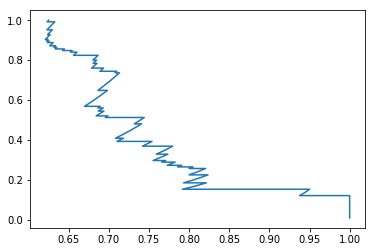

In [304]:
plt.plot(judgement_result[0]["prec"],judgement_result[0]["recall"])
plt.show()

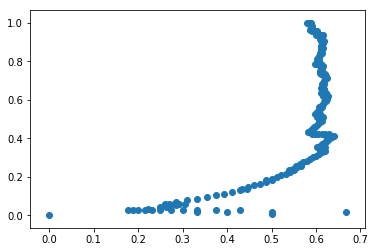

In [310]:
plt.scatter(judgement_result[1]["prec"],judgement_result[1]["recall"])
plt.show()

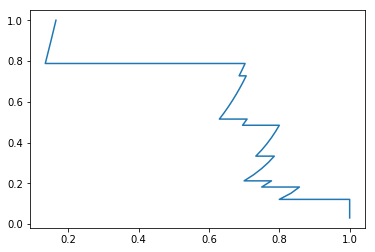

In [306]:
plt.plot(judgement_result[2]["prec"],judgement_result[2]["recall"])
plt.show()

In [307]:
judgement_result[1]

,prec,recall,f1
1,0.000000,0.000000,0.000000
2,0.500000,0.008621,0.016949
3,0.666667,0.017241,0.033613
4,0.500000,0.017241,0.033333
5,0.400000,0.017241,0.033058
6,0.333333,0.017241,0.032787
7,0.428571,0.025862,0.048780
8,0.375000,0.025862,0.048387
9,0.333333,0.025862,0.048000
10,0.300000,0.025862,0.047619


In [173]:
df_list_new

,prec,recall,f1
1,2,0.0519481,0.0998597
2,2.5,0.11177,0.207812
3,2.66667,0.171592,0.308986
4,2.5,0.22354,0.38886
5,2.2,0.230034,0.389492
6,2.16667,0.281982,0.462218
7,2.28571,0.341804,0.545526
8,2.25,0.393752,0.609877
9,2.22222,0.4457,0.670676
10,2.1,0.452193,0.665747


In [63]:
df_list_new

,prec,recall,f1
1,2,0.0519481,0.0998597
2,2.5,0.11177,0.207812
3,2.66667,0.171592,0.308986
4,2.5,0.22354,0.38886
5,2.2,0.230034,0.389492
6,2.16667,0.281982,0.462218
7,2.28571,0.341804,0.545526
8,2.25,0.393752,0.609877
9,2.22222,0.4457,0.670676
10,2.1,0.452193,0.665747


In [123]:
list(result_dict.values())[2]

[0.30939293073419183,          prec     recall         f1
 1           1  0.0454545  0.0869565
 2           1  0.0909091   0.166667
 3           1   0.136364       0.24
 4           1   0.181818   0.307692
 5         0.8   0.181818   0.296296
 6    0.833333   0.227273   0.357143
 7    0.857143   0.272727   0.413793
 8       0.875   0.318182   0.466667
 9    0.888889   0.363636   0.516129
 10        0.8   0.363636        0.5
 11   0.818182   0.409091   0.545455
 12   0.833333   0.454545   0.588235
 13   0.846154        0.5   0.628571
 14   0.857143   0.545455   0.666667
 15        0.8   0.545455   0.648649
 16     0.8125   0.590909   0.684211
 17   0.764706   0.590909   0.666667
 18   0.777778   0.636364        0.7
 19   0.736842   0.636364   0.682927
 20        0.7   0.636364   0.666667
 21   0.666667   0.636364   0.651163
 22   0.636364   0.636364   0.636364
 23   0.608696   0.636364   0.622222
 24      0.625   0.681818   0.652174
 25        0.6   0.681818   0.638298
 26   0.576923   

R-precision, Average Precision, nDCG, precision@k and recall@k and F1@k (k=5,10, 20, 50, 100). 
Average these numbers over the queryIDs. If run with -q option your program should display the 
measures for each queryID before displaying the averages